# Read in the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("datasets/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("datasets/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("datasets/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return string_representation.zfill(2)
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
# Convert SAT scores from strings to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Find latitude from given address string
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Find longitude from given address string
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Add lat and lon to hs_directory data frame
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
# Class size data set contains data for all classes
# and for all programs, we keep the data for 
# 9-12 grades and for program "GEN ED" only
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Since mutiple instances of same DBN are present
# group the data set by "DBN" column and take a mean
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# For demographics data consider data only for 2011-12
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

# Left join
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

# Inner join
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
combined["school_dist"] = combined["DBN"].apply(lambda x: x[0:2])

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Analyze correlation between SAT score and fields from survey data

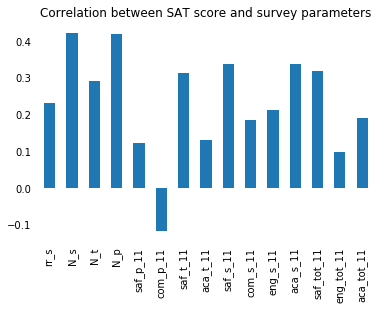

In [11]:
corr_survey = correlations[survey_fields]
corr_survey = corr_survey.dropna()

# keep correlations if more than 0.1
corr_survey = corr_survey[abs(corr_survey) > 0.1]

ax = corr_survey.plot.bar()
ax.set_title("Correlation between SAT score and survey parameters")

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.tick_params(left = 'off', right = 'off', top = 'off', bottom = 'off')

plt.show()

#### From corrlation bar plot we observe that saf_s_11 and saf_t_11 are corrlated with SAT score. Hence teacher and students prefer schools with higher safety (since they have higher SAT and score and hence more polular)


# Analyze SAT score and safety score

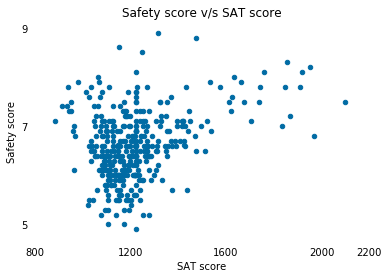

In [13]:
fig, ax = plt.subplots()

cb_blue = (0.0/255.0, 107.0/255.0, 164.0/255.0)
combined.plot(x = "sat_score", y = "saf_s_11", kind = "scatter", c =  cb_blue, ax = ax)

ax.set_title("Safety score v/s SAT score")
ax.set_xlabel('SAT score')
ax.set_ylabel('Safety score')

ax.tick_params(bottom = 'off', right = 'off', top = 'off', left = 'off')
ax.set_xticks([800, 1200, 1600, 2000, 2200])
ax.set_yticks([5,7,9])

for key, val in ax.spines.items():
    ax.spines[key].set_visible(False)

# Safety score by district

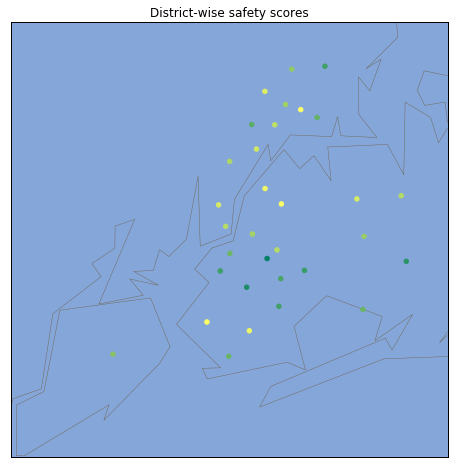

In [15]:
# Group and aggregate data by disctrict

districts = combined.groupby("school_dist")
districts = districts.agg(np.mean)
districts.reset_index(inplace = True)

fig, ax = plt.subplots(figsize = (8,8))

m = Basemap(projection = "merc",
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
            resolution='i')

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color = '#6D5F47', linewidth = 0.4)
m.drawrivers(color = '#6D5F47', linewidth = 0.4)

longitudes = districts["lon"].tolist()
latitudes  = districts["lat"].tolist()

m.scatter(longitudes, latitudes, latlon = True, 
          s = 20, c = districts["saf_s_11"], cmap = "summer",
          zorder = 2)

ax.set_title("District-wise safety scores")

plt.show()

# Exploring race and SAT scores

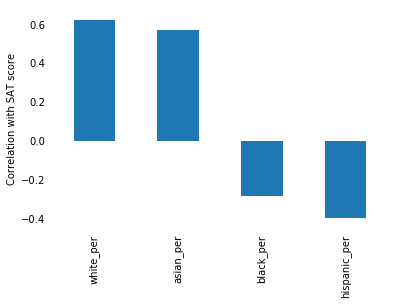

In [16]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_corr = correlations[races]

ax = race_corr.plot.bar()
ax.set_ylabel("Correlation with SAT score")

for key, val in ax.spines.items():
    ax.spines[key].set_visible(False)

ax.tick_params(left = 'off', right = 'off', top = 'off', bottom = 'off')

plt.show()

#### SAT score is strong positively correlated with white and asian races and is strong negatively correlated with hispanic race. Hence SAT seems to be an unfair test.

# Exploring SAT scores for hispanic

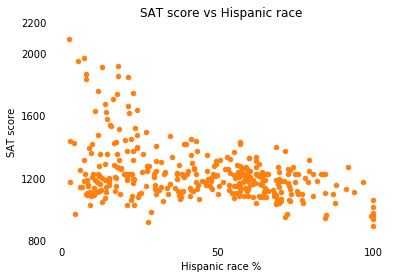

In [17]:
fig, ax = plt.subplots()

cb_orange = (255.0/255.0, 128.0/255.0, 14.0/255.0)
combined.plot(x = "hispanic_per", y = "sat_score", kind = "scatter", c =  cb_orange, ax = ax)

ax.set_title("SAT score vs Hispanic race")
ax.set_ylabel('SAT score')
ax.set_xlabel('Hispanic race %')

ax.tick_params(bottom = 'off', right = 'off', top = 'off', left = 'off')
ax.set_yticks([800, 1200, 1600, 2000, 2200])
ax.set_xticks([0,50,100])

for key, val in ax.spines.items():
    ax.spines[key].set_visible(False)
    
plt.show()

#### For schools with more tham 25% hispanic race, have low SAT score(less than 1500). 

# Exploring gender and SAT score

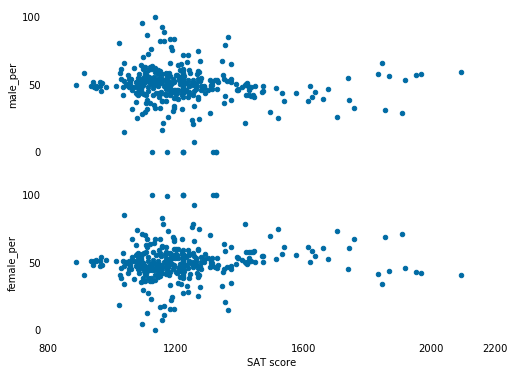

In [18]:
gender_cols = ['male_per', 'female_per']

fig = plt.figure(figsize = (8,6))

for i, col in enumerate(gender_cols):
    ax = fig.add_subplot(2,1,i+1)
    combined.plot(x = 'sat_score', y = col, kind = "scatter", c =  cb_blue, ax = ax)
    ax.set_ylabel(col)

    ax.tick_params(bottom = 'off', right = 'off', 
                   top = 'off', left = 'off', labelbottom = 'off')
    ax.set_xticks([800, 1200, 1600, 2000, 2200])
    ax.set_yticks([0,50,100])

    for key, val in ax.spines.items():
        ax.spines[key].set_visible(False)
    
    ax.xaxis.label.set_visible(False)

ax.xaxis.label.set_visible(True)    
ax.set_xlabel('SAT score')
ax.tick_params(labelbottom = 'on')
ax.set_xticks([800, 1200, 1600, 2000, 2200])

plt.show()

# Exploring AP scores vs SAT scores

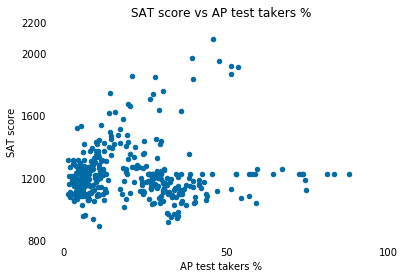

In [19]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"] *100

fig, ax = plt.subplots()

combined.plot(x = "ap_per", y = "sat_score", kind = "scatter", c =  cb_blue, ax = ax)

ax.set_title("SAT score vs AP test takers %")
ax.set_ylabel('SAT score')
ax.set_xlabel('AP test takers %')

ax.tick_params(bottom = 'off', right = 'off', top = 'off', left = 'off')
ax.set_yticks([800, 1200, 1600, 2000, 2200])
ax.set_xticks([0,50,100])

for key, val in ax.spines.items():
    ax.spines[key].set_visible(False)
    
plt.show()